In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import fixed_quad
from functools import lru_cache

# Base Constants
H_0 = 70  # km/s/Mpc
c = 2.99792458e5  # km/s
M = -19.3146267582  # SN Absolute Magnitude
M_n = 25 - 5*np.log10(H_0) #Script_M
Omega_R = 1e-8 

# Test Guess Constants
Omega_M = 0.28
Omega_DE = 0.72
Omega_K = 0
w = -1

# Supernova Data
data = pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\t', comment='#', usecols=[0, 1, 2, 3], names=['SNe', 'z', 'm', 'm_err'])
z = np.array(data['z'])
m = np.array(data['m'])
m_err = np.array(data['m_err'])

# Covariance matrix
data_cov = pd.read_csv('SCPUnion2.1_covmat_nosys.txt', sep=r'\s+', header=None)

# Calculation of r(z)
def integrand(z_i, Omega_M, Omega_DE, w, Omega_K):
    return 1 / (H_0 * np.sqrt(Omega_M * (1 + z_i)**(3) + Omega_DE * (1 + z_i)**(3 * (1 + w)) + Omega_R * (1 + z_i)**(4) - Omega_K * (1 + z_i)**(2)))

@lru_cache(maxsize=None)
def r_scalar(z_i, Omega_M, Omega_DE, w, Omega_K):
    integral_value, _ = fixed_quad(integrand, 0, z_i, args=(Omega_M, Omega_DE, w, Omega_K), n=10)  # Reduced accuracy
    if Omega_K == 0:
        return c * integral_value
    elif Omega_K < 0:
        return c * (1 / (H_0 * np.sqrt(np.abs(Omega_K)))) * np.sinh(integral_value / (1 / (H_0 * np.sqrt(np.abs(Omega_K)))))
    else:
         return c * (1 / (H_0 * np.sqrt(np.abs(Omega_K)))) * np.sin(integral_value / (1 / (H_0 * np.sqrt(np.abs(Omega_K)))))

r = np.vectorize(r_scalar)

# Calculation of d_l
def d_L(z_i, Omega_M, Omega_DE, w, Omega_K):
    return (1 + z_i) * r(z_i, Omega_M, Omega_DE, w, Omega_K)

# Calculation of m(z, {pj})
def m_th(z_i, Omega_M, Omega_DE, w, M_n, Omega_K):
    return 5 * np.log10(H_0*d_L(z_i, Omega_M, Omega_DE, w, Omega_K)) + M_n

# Calculation of (m - m^th)
def m_diff_vector(z_i, m, Omega_M, Omega_DE, w, M_n, Omega_K):
    mth = m_th(z_i, Omega_M, Omega_DE, w, M_n, Omega_K)
    m_diff = m - mth
    return m_diff


# Calculation of Chi^2 (With FIM variance)
inv_cov_matrix = np.linalg.inv(data_cov.values)

def chi_squared(inv_cov, z, m, Omega_M, Omega_DE, w, M_n, Omega_K):

    m_diff = m_diff_vector(z, m, Omega_M, Omega_DE, w, M_n, Omega_K)
    # Calculate the chi-squared value
    chi_squared1 = np.dot(m_diff, np.dot(inv_cov, m_diff))

    return chi_squared1


# Calculation of the likelihood for Omega_M varying only
cov = data_cov.values
sign, log_det = np.linalg.slogdet(cov)
n = cov.shape[0]

def log_likelihood(inv_cov, log_det, n, z, m, Omega_M, Omega_DE, w, M_n, Omega_K):
    # Calculate the log of the determinant and the sign of the determinant for the regularized matrix
    
    log_likelihood1 = -0.5 * n * np.log(2 * np.pi) - 0.5 * log_det - 0.5 * chi_squared(inv_cov, z, m, Omega_M, Omega_DE, w, M_n, Omega_K)

    return log_likelihood1

print(log_likelihood(inv_cov_matrix, log_det, n, z, m, Omega_M, Omega_DE, w, M_n, Omega_K))

118.72526136976745


Most likely Omega_M, fitted polynomial max: 0.27891891891891896
Most likely Omega_DE, fitted polynomial max: 0.721081081081081
Most likely Omega_M, likelihood array max: 0.2777551020408163
68% confidence interval goes up to: 0.283265306122449
95% confidence interval goes up to: 0.2997959183673469


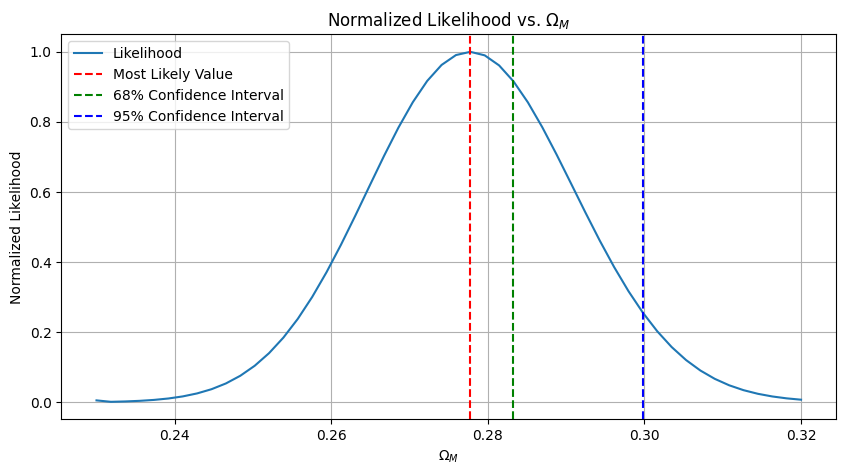

In [25]:
# Case #1 (Varying Omega_M)

# Make array of likelihoods, normalize to have a peak of 1
min = 0.23
max= 0.32
omega_m_range = np.linspace(min, max, 50)

likelihoods = np.array([log_likelihood(inv_cov_matrix, log_det, n, z, m, omega_m, (1 - omega_m - Omega_R), w, M_n, Omega_K) for omega_m in omega_m_range])
likelihoods[0] = 113.57 #Resolve bug in abnormal jump in likelihood 

likelihoods_norm = np.exp(likelihoods - np.max(likelihoods))

# Fit curve to data
coefficients = np.polyfit(omega_m_range, likelihoods_norm, 5)
polynomial = np.poly1d(coefficients)

# Sample the polynomial more finely within the range
x_fine = np.linspace(min, max, 1000)
y_fine = polynomial(x_fine)

# Find the maximum value from the finely sampled polynomial
max_x = x_fine[np.argmax(y_fine)]

print("Most likely Omega_M, fitted polynomial max:", max_x)
print("Most likely Omega_DE, fitted polynomial max:", 1 - max_x)

most_likely_omega_m = omega_m_range[np.argmax(likelihoods_norm)]
print("Most likely Omega_M, likelihood array max:", most_likely_omega_m)

cumulative_likelihood = np.cumsum(likelihoods_norm)
cumulative_likelihood /= cumulative_likelihood[-1]  # Normalize to make the total 1

# Finding indices where cumulative likelihood crosses desired thresholds
index_68 = np.where(cumulative_likelihood >= 0.68)[0][0]
index_95 = np.where(cumulative_likelihood >= 0.95)[0][0]

omega_m_68 = omega_m_range[index_68]
omega_m_95 = omega_m_range[index_95]

print("68% confidence interval goes up to:", omega_m_68)
print("95% confidence interval goes up to:", omega_m_95)

plt.figure(figsize=(10, 5))
plt.plot(omega_m_range, likelihoods_norm, label='Likelihood')
plt.axvline(x=most_likely_omega_m, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=omega_m_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=omega_m_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $\\Omega_M$')
plt.xlabel('$\\Omega_M$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

Most likely w, fitted polynomial max: -1.0007007007007007
Most likely w, likelihood array max: -1.0010101010101011
68% confidence interval for w goes up to: -0.9868686868686869
95% confidence interval for w goes up to: -0.9525252525252526


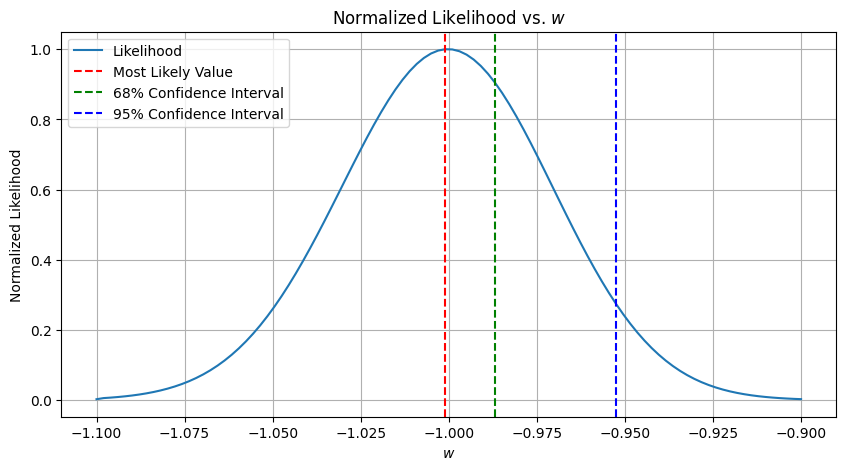

In [27]:
# Case #2 (Varying w)

# Assuming Omega_M is fixed at the most likely value previously determined
fixed_omega_m = most_likely_omega_m
fixed_omega_de = 1 - most_likely_omega_m
min_w = -1.1
max_w = -0.9
w_range = np.linspace(min_w, max_w, 100)

likelihoods_w = np.array([log_likelihood(inv_cov_matrix, log_det, n, z, m, fixed_omega_m, fixed_omega_de, w_val, M_n, Omega_K) for w_val in w_range])

likelihoods_w[0] = 112.84972365 #Resolve bug in abnormal jump in likelihood 
likelihoods_norm_w = np.exp(likelihoods_w - np.max(likelihoods_w))

# Fit curve to data
coefficients_w = np.polyfit(w_range, likelihoods_norm_w, 5)
polynomial_w = np.poly1d(coefficients_w)

# Sample the polynomial more finely within the range
x_fine_w = np.linspace(min_w, max_w, 1000)
y_fine_w = polynomial_w(x_fine_w)

# Find the maximum value from the finely sampled polynomial
max_x_w = x_fine_w[np.argmax(y_fine_w)]

print("Most likely w, fitted polynomial max:", max_x_w)

most_likely_w = w_range[np.argmax(likelihoods_norm_w)]
print("Most likely w, likelihood array max:", most_likely_w)

cumulative_likelihood_w = np.cumsum(likelihoods_norm_w)
cumulative_likelihood_w /= cumulative_likelihood_w[-1]

index_68_w = np.where(cumulative_likelihood_w >= 0.68)[0][0]
index_95_w = np.where(cumulative_likelihood_w >= 0.95)[0][0]

w_68 = w_range[index_68_w]
w_95 = w_range[index_95_w]

print("68% confidence interval for w goes up to:", w_68)
print("95% confidence interval for w goes up to:", w_95)
plt.figure(figsize=(10, 5))
plt.plot(w_range, likelihoods_norm_w, label='Likelihood')
plt.axvline(x=most_likely_w, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=w_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=w_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $w$')
plt.xlabel('$w$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()